In [1]:
import pandas as pd
import fastf1
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import datetime as dt


In [2]:
YEAR = 2022
DRIVER_NUM = '16'
ROUND = 7
DRIVER_REF = 'LEC'


In [23]:
fastf1.Cache.enable_cache('/Users/nooralindeflaten/f1_ML_predictor/data/cache/')
session = fastf1.get_session(YEAR,ROUND,'R')
session.load()

leclerc_laps = session.laps[session.laps['Driver'] == 'LEC']
sainz_laps = session.laps[session.laps['Driver'] == 'SAI']
verstappen_laps = session.laps[session.laps['Driver'] == 'VER']
hamilton_laps = session.laps[session.laps['Driver'] == 'HAM']


core           INFO 	Loading data for Monaco Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['11', '55', '1', '16', '63', '4', '14', '44', '77', '5', '10', '31', '3', '18', '6', '24', '22', '23', '47', '20']


Getting all data for leclerc
What's the difference between having an _ before the method?

In [21]:

def extract_lap_data(laps, lap_number):
    lap = laps[laps['LapNumber'] == lap_number].iloc[0]
    return lap.get_car_data(), lap.get_pos_data()

def run_linear_regression(X, y):
    model = LinearRegression()
    model.fit(X, y)
    return model, model.coef_, model.intercept_

def average_sector_diffs(laps):
    sector_diffs = {'Sector1': [], 'Sector2': [], 'Sector3': []}
    for i in range(1, len(laps)):
        for sector in ['Sector1Time', 'Sector2Time', 'Sector3Time']:
            try:
                delta = laps.iloc[i][sector] - laps.iloc[i-1][sector]
                sector_diffs[sector].append(delta.total_seconds())
            except:
                continue
    return sector_diffs

### utils.py
def print_lap_summary(laps):
    for i, lap in laps.iterrows():
        print(f"Lap {lap['LapNumber']}: {lap['LapTime']}")



In [5]:
import pandas as pd

# Assuming you have the lap data for multiple drivers loaded in 'laps_df'
# Group by 'Driver' to separate analysis by each driver
# Then, group by 'Stint' and 'Compound' to analyze tire strategy during each stint
def analyze_stints_and_tires(laps_df):
    # Filtering for relevant columns first
    relevant_columns = ['Driver', 'Stint', 'Compound', 'LapNumber', 'LapTime', 'TyreLife', 'Position']
    laps_df = laps_df[relevant_columns]

    # Group by Driver, Stint, and Compound to track tire usage and performance
    stint_analysis = laps_df.groupby(['Driver', 'Stint', 'Compound']).agg(
        total_laps=('LapNumber', 'count'),
        avg_lap_time=('LapTime', 'mean'),
        avg_tyre_life=('TyreLife', 'mean'),
        avg_position=('Position', 'mean')
    ).reset_index()

    # Display analysis for a quick look at strategy
    return stint_analysis


# Adjusted function to handle sector session times
def analyze_single_lap_with_sectors(driver_lap, car_data, pos_data):
    # Create a new DataFrame to hold telemetry and position data together
    telemetry_data = pd.merge_asof(
        car_data, pos_data, on='SessionTime', direction='nearest'
    )

    # Calculate some additional metrics or filter further based on interest
    telemetry_data['Speed'] = telemetry_data['Speed']
    telemetry_data['RPM'] = telemetry_data['RPM']
    telemetry_data['Throttle'] = telemetry_data['Throttle']
    telemetry_data['Brake'] = telemetry_data['Brake']

    # Calculate max speed, average RPM, etc.
    lap_analysis = {
        'Max Speed': telemetry_data['Speed'].max(),
        'Avg RPM': telemetry_data['RPM'].mean(),
        'Max Throttle': telemetry_data['Throttle'].max(),
        'Max Brake': telemetry_data['Brake'].max(),
        'Track Positions (X, Y, Z)': telemetry_data[['X', 'Y', 'Z']].describe(),
    }

    # Sector data for the lap (if applicable)
    sector_times = {
        'Sector 1 Time': driver_lap['Sector1SessionTime'].max(),
        'Sector 2 Time': driver_lap['Sector2SessionTime'].max(),
        'Sector 3 Time': driver_lap['Sector3SessionTime'].max(),
    }

    print(f"Analysis for Driver: LEC, Lap Number: {driver_lap['LapNumber']}")
    return lap_analysis, telemetry_data, sector_times


single_lap = verstappen_laps[verstappen_laps['LapNumber']==47]
print(single_lap)
lec_pos, lec_car = single_lap.get_pos_data(), single_lap.get_car_data()
analyze_single_lap_with_sectors(single_lap,lec_car,lec_pos)

                     Time Driver DriverNumber                LapTime  \
46 0 days 03:38:26.715000    VER            1 0 days 00:01:16.052000   

    LapNumber  Stint PitOutTime PitInTime            Sector1Time  \
46       47.0    4.0        NaT       NaT 0 days 00:00:20.213000   

              Sector2Time  ... FreshTyre             Team  \
46 0 days 00:00:35.724000  ...      True  Red Bull Racing   

             LapStartTime            LapStartDate  TrackStatus  Position  \
46 0 days 03:37:10.663000 2022-05-29 15:38:10.684            1       3.0   

    Deleted  DeletedReason FastF1Generated IsAccurate  
46    False                          False       True  

[1 rows x 31 columns]
Analysis for Driver: LEC, Lap Number: 46    47.0
Name: LapNumber, dtype: float64


({'Max Speed': 270.0,
  'Avg RPM': 9510.013986013986,
  'Max Throttle': 100.0,
  'Max Brake': True,
  'Track Positions (X, Y, Z)':                  X            Y           Z
  count   286.000000   286.000000  286.000000
  mean  -4038.594406 -4274.500000  599.006993
  std    2631.294675  3008.141623  134.991150
  min   -7681.000000 -9767.000000  476.000000
  25%   -6751.750000 -6289.000000  491.250000
  50%   -4116.000000 -4249.500000  541.000000
  75%   -1273.250000 -1305.000000  674.000000
  max    -210.000000  -195.000000  895.000000},
                      Date_x      RPM  Speed  nGear  Throttle  Brake  DRS  \
 0   2022-05-29 15:38:10.944  10665.0  264.0      7     100.0  False    0   
 1   2022-05-29 15:38:11.144  10497.0  268.0      7     100.0  False    0   
 2   2022-05-29 15:38:11.304  10497.0  267.0      7      12.0  False    0   
 3   2022-05-29 15:38:11.544  10296.0  265.0      7       0.0  False    0   
 4   2022-05-29 15:38:11.704  10231.0  258.0      7       0.0   True  

In [24]:
# Leclerc analysis
lap_acc = leclerc_laps.pick_accurate
lap_in = leclerc_laps.PitInTime
lap_out = leclerc_laps.PitOutTime
lap_pos = leclerc_laps.Position
lap_box = leclerc_laps.get_weather_data

single_lap = leclerc_laps[leclerc_laps['LapNumber'] == 1]
#print(single_lap)
ham_single_lap = hamilton_laps[hamilton_laps['LapNumber'] == 1]
lec_pos_data, lec_car_data = single_lap.get_pos_data(),single_lap.get_car_data()
#single_lap
ham_pos_data, ham_car_data = ham_single_lap.get_pos_data(), ham_single_lap.get_car_data()

In [ ]:
print(track['Message'])

/Users/nooralindeflaten/anaconda3/envs/INF273/lib/python3.11/site-packages/fastf1/plotting/_plotting.py:90: FutureWarning: FastF1 will no longer silently modify the default Matplotlib colors in the future.
To remove this warning, explicitly set `color_scheme=None` or `color_scheme='fastf1'` when calling `.setup_mpl()`.
  warnings.warn(


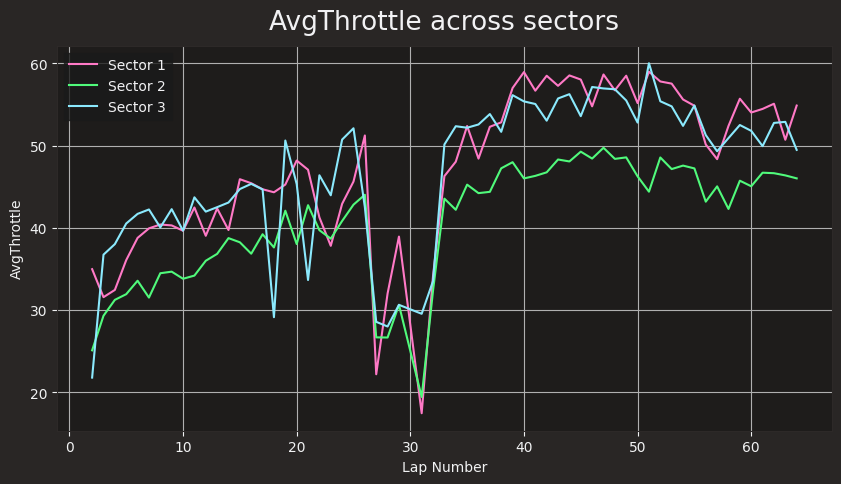

,Stint,LapTime,Compound,TyreLife,LapNumber,Sector,AvgSpeed,AvgThrottle,AvgBrake,AvgRPM,TrackStatus
0,2.0,0 days 00:02:24.979000,INTERMEDIATE,2.0,2.0,1,106.027079,34.961367,0.411765,8317.368489,14
1,2.0,0 days 00:02:24.979000,INTERMEDIATE,2.0,2.0,2,79.869195,25.088965,0.349593,7646.976179,14
2,2.0,0 days 00:02:24.979000,INTERMEDIATE,2.0,2.0,3,72.874000,21.772146,0.192529,6741.002278,14
3,2.0,0 days 00:01:43.218000,INTERMEDIATE,3.0,3.0,1,136.044136,31.555193,0.349515,9176.859755,1
4,2.0,0 days 00:01:43.218000,INTERMEDIATE,3.0,3.0,2,106.446671,29.293452,0.350829,7712.624295,1
...,...,...,...,...,...,...,...,...,...,...,...
181,4.0,0 days 00:01:17.729000,HARD,42.0,63.0,2,137.978542,46.366588,0.364662,9074.582029,1
182,4.0,0 days 00:01:17.729000,HARD,42.0,63.0,3,148.400607,52.879400,0.341772,9288.568755,1
183,4.0,0 days 00:01:18.338000,HARD,43.0,64.0,1,185.395590,54.860264,0.343949,10166.945565,1
184,4.0,0 days 00:01:18.338000,HARD,43.0,64.0,2,134.006032,46.004624,0.335689,8928.153317,1


In [25]:
import fastf1.plotting
fastf1.plotting.setup_mpl(misc_mpl_mods=False)

def analyze_driver_sectors(driver_laps):
    sector_stats = []

    for _, lap in driver_laps.iterrows():
        telemetry = lap.get_telemetry()
        
        s1_end = lap['Sector1SessionTime']
        s2_end = lap['Sector2SessionTime']
        s3_end = lap['Sector3SessionTime']

        if pd.isna(s1_end) or pd.isna(s2_end) or pd.isna(s3_end):
            continue

        sector1 = telemetry[telemetry['SessionTime'] <= s1_end]
        sector2 = telemetry[(telemetry['SessionTime'] > s1_end) & (telemetry['SessionTime'] <= s2_end)]
        sector3 = telemetry[telemetry['SessionTime'] > s2_end]

        def summarize(sector_data, sector_num):
            return {
                'Stint': lap['Stint'],
                'LapTime': lap['LapTime'],
                'Compound': lap['Compound'],
                'TyreLife': lap['TyreLife'],
                'LapNumber': lap['LapNumber'],
                'Sector': sector_num,
                'AvgSpeed': sector_data['Speed'].mean(),
                'AvgThrottle': sector_data['Throttle'].mean(),
                'AvgBrake': sector_data['Brake'].astype(float).mean(),
                'AvgRPM': sector_data['RPM'].mean(),
                'TrackStatus': lap['TrackStatus']
            }

        sector_stats.extend([
            summarize(sector1, 1),
            summarize(sector2, 2),
            summarize(sector3, 3),
        ])

    return pd.DataFrame(sector_stats)

# Example usage:
# session = fastf1.get_session(2022, "Monaco", "R")
# session.load()
leclerc_sectors = analyze_driver_sectors(leclerc_laps)

# Plot average speed per sector across laps
def plot_sector_trends(sector_df, metric="AvgSpeed"):
    plt.figure(figsize=(10, 5))
    for sector in [1, 2, 3]:
        sector_data = sector_df[sector_df['Sector'] == sector]
        plt.plot(sector_data['LapNumber'], sector_data[metric], label=f"Sector {sector}")
    plt.xlabel("Lap Number")
    plt.ylabel(metric)
    plt.title(f"{metric} across sectors")
    plt.legend()
    plt.grid(True)
    plt.show()

#plot_sector_trends(leclerc_sectors, "AvgSpeed")
plot_sector_trends(leclerc_sectors, "AvgThrottle")
leclerc_sectors

In [26]:
# Assuming you already have the laps DataFrame filtered for Leclerc
ls = leclerc_sectors[leclerc_sectors['LapNumber'] == 46.0]
leclerc_laps = leclerc_laps[leclerc_laps['LapTime'].notna()]

# Convert LapTime from Timedelta to seconds for analysis
leclerc_laps['LapTimeSeconds'] = leclerc_laps['LapTime'].dt.total_seconds()

# Grouping by stint to calculate average lap degradation trend
stint_degradation = leclerc_laps.groupby(['Stint', 'TyreLife', 'Compound']).agg({
    'LapTimeSeconds': 'mean',
    'TrackStatus': 'first',  # or whatever you want to look at later
}).reset_index()

lecl_laps_inters = leclerc_sectors[leclerc_sectors['Compound'] == 'INTERMEDIATE']



/var/folders/t_/y1zy_tj51c35tggpc_c8twp40000gn/T/ipykernel_54318/2878299889.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  leclerc_laps['LapTimeSeconds'] = leclerc_laps['LapTime'].dt.total_seconds()


In [27]:
# Calculate average RPM, Throttle, and Speed for each compound and tire life group
leclerc_sectors['LapTimeSeconds'] = leclerc_sectors['LapTime'].dt.total_seconds()

tire_comparison = leclerc_sectors.groupby(['Stint', 'Compound', 'TyreLife']).agg({
    'LapTimeSeconds': 'mean',
    'AvgRPM': 'mean',
    'AvgThrottle': 'mean',
    'AvgSpeed': 'mean'
}).reset_index()

tire_comparison
# Plot this comparison



,Stint,Compound,TyreLife,LapTimeSeconds,AvgRPM,AvgThrottle,AvgSpeed
0,2.0,INTERMEDIATE,2.0,144.979,7568.448982,27.274159,86.256758
1,2.0,INTERMEDIATE,3.0,103.218,8518.680119,32.524688,118.443506
2,2.0,INTERMEDIATE,4.0,101.885,8648.900915,33.890036,118.918633
3,2.0,INTERMEDIATE,5.0,99.679,8573.131636,36.164186,123.931073
4,2.0,INTERMEDIATE,6.0,98.046,8679.119775,38.002142,126.437748
...,...,...,...,...,...,...,...
57,4.0,HARD,39.0,78.678,9383.322647,50.281461,153.793674
58,4.0,HARD,40.0,78.832,9376.347993,50.357648,152.215736
59,4.0,HARD,41.0,78.539,9370.989131,51.488292,153.085118
60,4.0,HARD,42.0,77.729,9497.275131,49.982399,156.964467


# The position data:


Date	Status	X	Y	Z	Source	Time	SessionTime
0	2022-05-29 14:05:00.382	OnTrack	-5956.0	-4411.0	512.0	pos	0 days 00:00:00.155000	0 days 02:04:00.361000

# Car data:
Date	RPM	Speed	nGear	Throttle	Brake	DRS	Source	Time	SessionTime
0	2022-05-29 14:05:00.448	4055.0	0.0	0	0.0	False	1	car	0 days 00:00:00.221000	0 days 02:04:00.427000

# lap data:
Time	Driver	DriverNumber	LapTime	LapNumber	Stint	PitOutTime	PitInTime	Sector1Time	Sector2Time	...	FreshTyre	Team	LapStartTime	LapStartDate	TrackStatus	Position	Deleted	DeletedReason	FastF1Generated	IsAccurate


# .pick_box_laps

Time	Driver	DriverNumber	LapTime	LapNumber	Stint	PitOutTime	PitInTime	Sector1Time	Sector2Time	...	FreshTyre	Team	LapStartTime	LapStartDate

# Telemetry

Date, SessionTime	DriverAhead	DistanceToDriverAhead	Time	RPM	Speed	nGear	Throttle	Brake	DRS	Source	Distance	RelativeDistance	Status	X	Y	Z



	Stint	LapTime	Compound	TyreLife	LapNumber	Sector	AvgSpeed	AvgThrottle	AvgBrake	AvgRPM
0	2.0	0 days 00:02:24.979000	INTERMEDIATE	2.0	2.0	1	106.027079	34.961367	0.411765	8317.368489
1	2.0	0 days 00:02:24.979000	INTERMEDIATE	2.0	2.0	2	79.869195	25.088965	0.349593	7646.976179
2	2.0	0 days 00:02:24.979000	INTERMEDIATE	2.0	2.0	3	72.874000	21.772146	0.192529	6741.002278
3	2.0	0 days 00:01:43.218000	INTERMEDIATE	3.0	3.0	1	136.044136	31.555193	0.349515	9176.859755
4	2.0	0 days 00:01:43.218000	INTERMEDIATE	3.0	3.0	2	106.446671	29.293452	0.350829	7712.624295
...	...	...	...	...	...	...	...	...	...	...
178	4.0	0 days 00:01:17.729000	HARD	42.0	63.0	2	137.978542	46.366588	0.364662	9074.582029
179	4.0	0 days 00:01:17.729000	HARD	42.0	63.0	3	148.400607	52.879400	0.341772	9288.568755
180	4.0	0 days 00:01:18.338000	HARD	43.0	64.0	1	185.395590	54.860264	0.343949	10166.945565
181	4.0	0 days 00:01:18.338000	HARD	43.0	64.0	2	134.006032	46.004624	0.335689	8928.153317
182	4.0	0 days 00:01:18.338000	HARD	43.0	64.0	3	145.575932	49.472260	0.370861	9244.682869


     Stint                LapTime Compound  TyreLife  LapNumber  Sector  \
126    4.0 0 days 00:01:16.249000     HARD      25.0       46.0       1   
127    4.0 0 days 00:01:16.249000     HARD      25.0       46.0       2   
128    4.0 0 days 00:01:16.249000     HARD      25.0       46.0       3   

       AvgSpeed  AvgThrottle  AvgBrake        AvgRPM  
126  183.551614    54.766571  0.324324  10046.190579  
127  136.883012    48.412670  0.321970   9003.137262  
128  150.944572    57.118466  0.306250   9448.221037





### Tyre, Average statistics, and stint analysis. 


	Stint	LapTime	Compound	TyreLife	LapNumber	Sector	AvgSpeed	AvgThrottle	AvgBrake	AvgRPM
0	2.0	0 days 00:02:24.979000	INTERMEDIATE	2.0	2.0	1	106.027079	34.961367	0.411765	8317.368489
1	2.0	0 days 00:02:24.979000	INTERMEDIATE	2.0	2.0	2	79.869195	25.088965	0.349593	7646.976179
2	2.0	0 days 00:02:24.979000	INTERMEDIATE	2.0	2.0	3	72.874000	21.772146	0.192529	6741.002278
3	2.0	0 days 00:01:43.218000	INTERMEDIATE	3.0	3.0	1	136.044136	31.555193	0.349515	9176.859755
4	2.0	0 days 00:01:43.218000	INTERMEDIATE	3.0	3.0	2	106.446671	29.293452	0.350829	7712.624295
...	...	...	...	...	...	...	...	...	...	...
178	4.0	0 days 00:01:17.729000	HARD	42.0	63.0	2	137.978542	46.366588	0.364662	9074.582029
179	4.0	0 days 00:01:17.729000	HARD	42.0	63.0	3	148.400607	52.879400	0.341772	9288.568755
180	4.0	0 days 00:01:18.338000	HARD	43.0	64.0	1	185.395590	54.860264	0.343949	10166.945565
181	4.0	0 days 00:01:18.338000	HARD	43.0	64.0	2	134.006032	46.004624	0.335689	8928.153317
182	4.0	0 days 00:01:18.338000	HARD	43.0	64.0	3	145.575932	49.472260	0.370861	9244.682869



# analysis

Analysis for Driver: LEC, Lap Number: 301    46.0
Name: LapNumber, dtype: float64
({'Max Speed': 283.0,
  'Avg RPM': 9374.332142857143,
  'Max Throttle': 100.0,
  'Max Brake': True,
  'Track Positions (X, Y, Z)':                  X            Y           Z
  count   280.000000   280.000000  280.000000
  mean  -4186.771429 -4435.939286  588.417857
  std    2638.087726  3073.739095  130.048958
  min   -7677.000000 -9764.000000  477.000000
  25%   -6779.250000 -6973.000000  490.000000
  50%   -4437.000000 -4429.000000  540.000000
  75%   -1414.250000 -1308.000000  655.000000
  max    -210.000000  -194.000000  895.000000},
                      Date_x      RPM  Speed  nGear  Throttle  Brake  DRS  \
 0   2022-05-29 15:36:56.103  10742.0  266.0      7     100.0  False    0   
 1   2022-05-29 15:36:56.463  10867.0  267.0      7     100.0  False    0   
 2   2022-05-29 15:36:56.663  10902.0  271.0      7     100.0  False    0   
 3   2022-05-29 15:36:56.943  10848.0  270.0      7       3.0   True    0   
 4   2022-05-29 15:36:57.103  10433.0  260.0      7       0.0   True    0   
 ..                      ...      ...    ...    ...       ...    ...  ...   
 275 2022-05-29 15:38:11.144  11505.0  249.0      6     100.0  False    0   
 276 2022-05-29 15:38:11.304  11595.0  251.0      6     100.0  False    0   
 277 2022-05-29 15:38:11.544  11695.0  255.0      6     100.0  False    0   
 278 2022-05-29 15:38:11.704  11135.0  258.0      6     100.0  False    0   
 279 2022-05-29 15:38:11.944  10456.0  260.0      7     100.0  False    0   
...
 
 [280 rows x 17 columns],
 {'Sector 1 Time': Timedelta('0 days 03:36:16.066000'),
  'Sector 2 Time': Timedelta('0 days 03:36:51.855000'),
  'Sector 3 Time': Timedelta('0 days 03:37:12.185000')})



  ({'Max Speed': 269.0,
  'Avg RPM': 9442.516014234876,
  'Max Throttle': 100.0,
  'Max Brake': True,
  'Track Positions (X, Y, Z)':                  X            Y           Z
  count   281.000000   281.000000  281.000000
  mean  -4175.601423 -4413.797153  587.676157
  std    2637.502207  3072.490280  129.127007
  min   -7675.000000 -9767.000000  476.000000
  25%   -6785.000000 -6861.000000  490.000000
  50%   -4521.000000 -4435.000000  540.000000
  75%   -1412.000000 -1344.000000  646.000000
  max    -210.000000  -194.000000  896.000000},
                      Date_x      RPM  Speed  nGear  Throttle  Brake  DRS  \
 0   2022-05-29 15:36:54.143  10538.0  262.0      7     100.0  False    0   
 1   2022-05-29 15:36:54.343  10667.0  266.0      7     100.0  False    0   
 2   2022-05-29 15:36:54.703   9970.0  263.0      7       0.0  False    0   
 3   2022-05-29 15:36:54.863  10118.0  261.0      7       0.0  False    0   
 4   2022-05-29 15:36:55.183   9601.0  247.0      7       0.0   True    0   
 ..                      ...      ...    ...    ...       ...    ...  ...   
 276 2022-05-29 15:38:09.423  11013.0  242.0      6     100.0  False    0   
 277 2022-05-29 15:38:09.663  11242.0  247.0      6     100.0  False    0   
 278 2022-05-29 15:38:10.063  11423.0  252.0      6     100.0  False    0   
 279 2022-05-29 15:38:10.303  11518.0  258.0      6     100.0  False    0   
 280 2022-05-29 15:38:10.503  10971.0  261.0      6     100.0  False    0   
...
 
 [281 rows x 17 columns],
 {'Sector 1 Time': Timedelta('0 days 03:36:14.365000'),
  'Sector 2 Time': Timedelta('0 days 03:36:50.385000'),
  'Sector 3 Time': Timedelta('0 days 03:37:10.713000')})

                LapTimeSeconds  AvgSpeed  AvgThrottle  AvgBrake    AvgRPM  \
LapTimeSeconds        1.000000 -0.714838    -0.911638 -0.148008 -0.582258   
AvgSpeed             -0.714838  1.000000     0.807554  0.312882  0.905743   
AvgThrottle          -0.911638  0.807554     1.000000  0.174936  0.701165   
AvgBrake             -0.148008  0.312882     0.174936  1.000000  0.371729   
AvgRPM               -0.582258  0.905743     0.701165  0.371729  1.000000   
TyreLife             -0.471933  0.388668     0.540351  0.065280  0.278316   

                TyreLife  
LapTimeSeconds -0.471933  
AvgSpeed        0.388668  
AvgThrottle     0.540351  
AvgBrake        0.065280  
AvgRPM          0.278316  
TyreLife        1.000000  


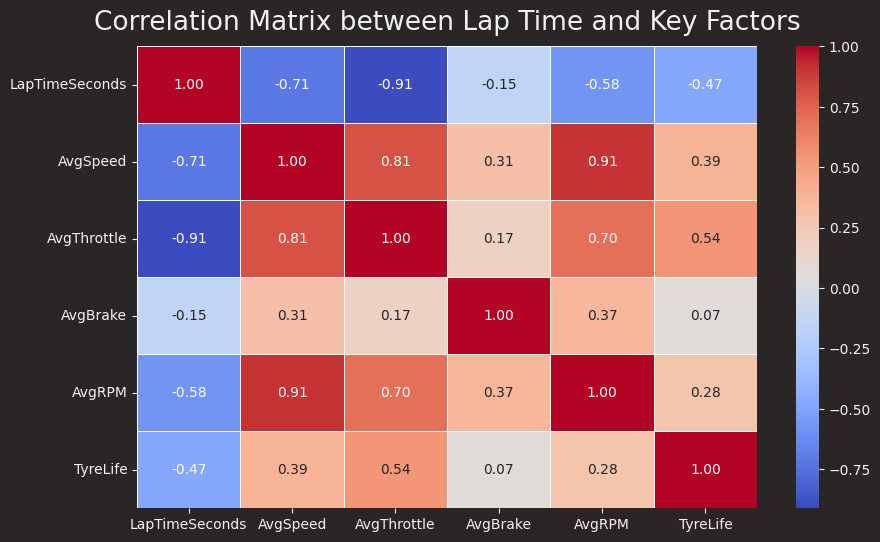

Impact of AvgSpeed on lap time:
Slope: nan, R-squared: nan, P-value: nan
----


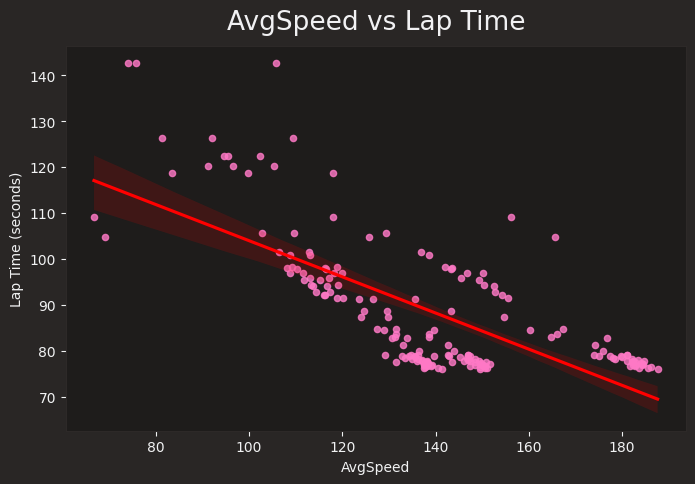

Impact of AvgThrottle on lap time:
Slope: nan, R-squared: nan, P-value: nan
----


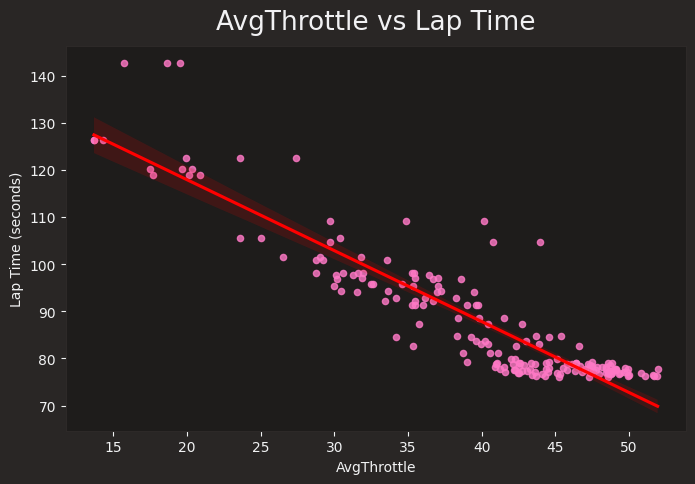

Impact of AvgBrake on lap time:
Slope: nan, R-squared: nan, P-value: nan
----


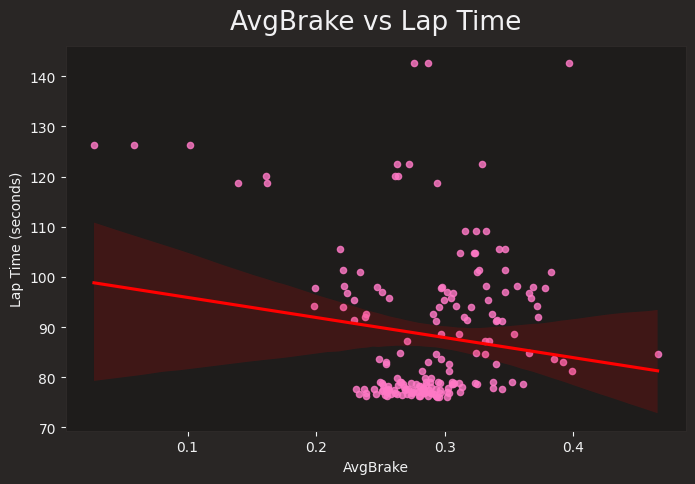

Impact of AvgRPM on lap time:
Slope: nan, R-squared: nan, P-value: nan
----


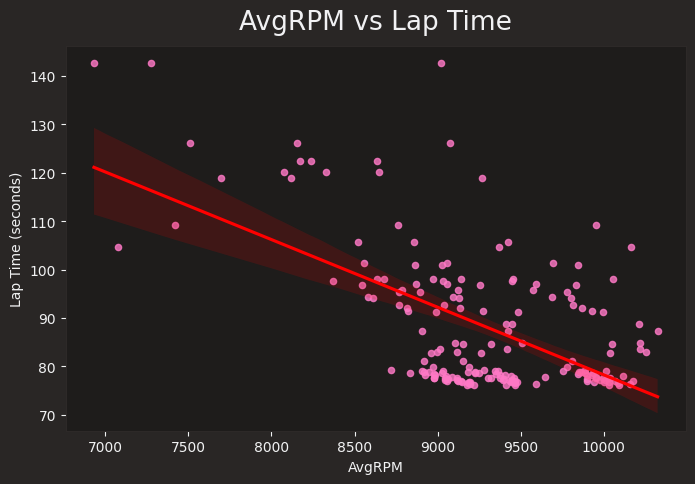

Impact of TyreLife on lap time:
Slope: nan, R-squared: nan, P-value: nan
----


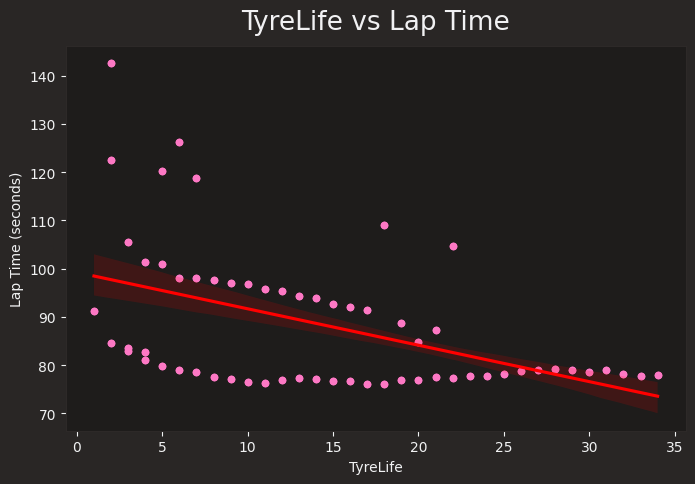

In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress

def analyze_factors(data):
    """
    Analyzes the key factors that affect lap time, including tire life, RPM, throttle, and speed.
    Outputs the correlation matrix and detailed impact of each factor on lap time.
    """
    # 1. Convert time to seconds for easier analysis
    data['LapTimeSeconds'] = data['LapTime'].dt.total_seconds()

    # 2. Calculate the correlation matrix between lap time and other variables
    correlation_matrix = data[['LapTimeSeconds', 'AvgSpeed', 'AvgThrottle', 'AvgBrake', 'AvgRPM', 'TyreLife']].corr()

    # Display the correlation matrix
    print(correlation_matrix)
    plt.figure(figsize=(10, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title("Correlation Matrix between Lap Time and Key Factors")
    plt.show()

    # 3. Impact of each factor on lap time (using linear regression for simplicity)
    factors = ['AvgSpeed', 'AvgThrottle', 'AvgBrake', 'AvgRPM', 'TyreLife']
    for factor in factors:
        # Perform linear regression
        slope, intercept, r_value, p_value, std_err = linregress(data[factor], data['LapTimeSeconds'])

        # Print the impact of the factor on lap time
        print(f"Impact of {factor} on lap time:")
        print(f"Slope: {slope:.2f}, R-squared: {r_value**2:.2f}, P-value: {p_value:.4f}")
        print("----")

        # Plot the relationship between the factor and lap time
        plt.figure(figsize=(8, 5))
        sns.regplot(x=factor, y='LapTimeSeconds', data=data, scatter_kws={'s': 20}, line_kws={"color": "red"})
        plt.title(f"{factor} vs Lap Time")
        plt.xlabel(f"{factor}")
        plt.ylabel("Lap Time (seconds)")
        plt.show()

    # 4. Plot tire life vs lap time to check degradation trend
    #plt.figure(figsize=(10, 6))
    #sns.lineplot(data=data, x='TyreLife', y='LapTimeSeconds', hue='Compound', markers=True)
    #plt.title("Lap Time vs Tire Life by Compound")
    #plt.xlabel("Tire Life (laps)")
    #plt.ylabel("Lap Time (seconds)")
    #plt.grid(True)
    #plt.show()

# Now call the function to analyze the data
verstappen_sectors = analyze_driver_sectors(verstappen_laps)
analyze_factors(verstappen_sectors)  # Replace `leclerc_data` with your actual dataframe
ham_sector = analyze_driver_sectors(hamilton_laps)

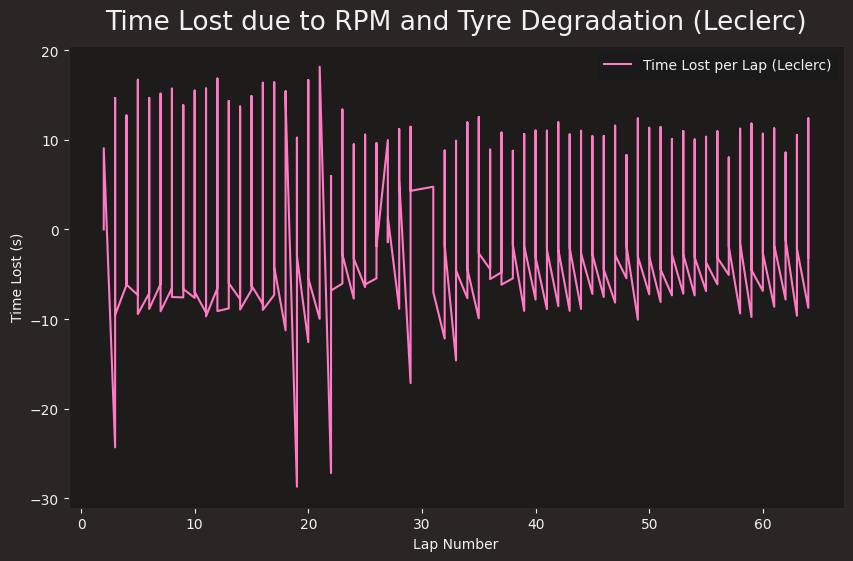

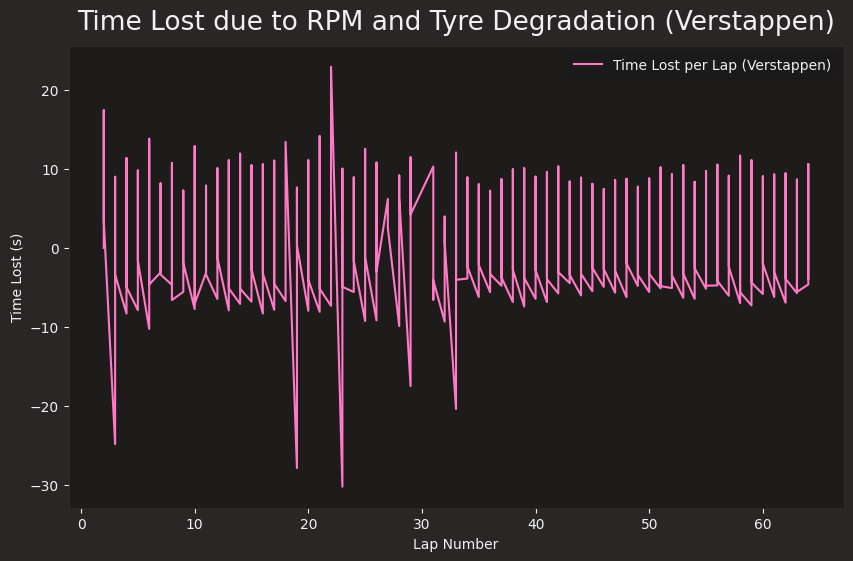

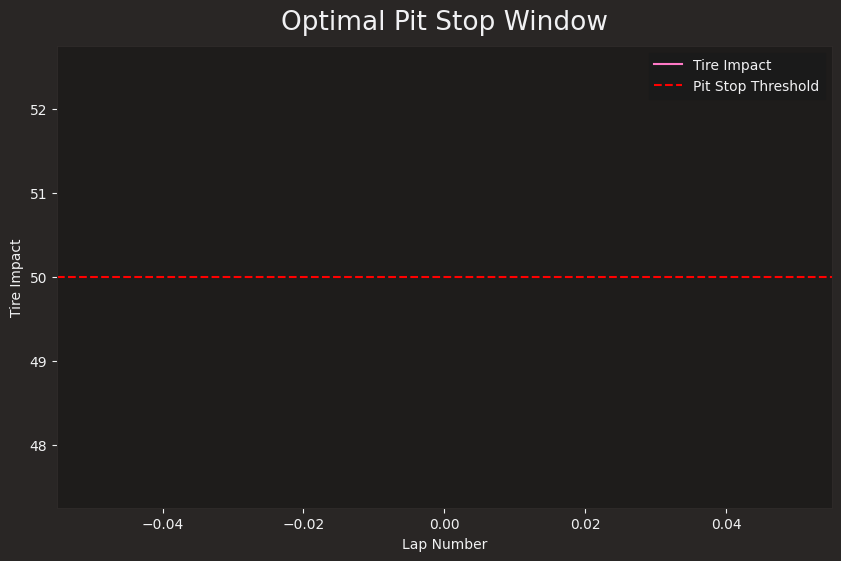

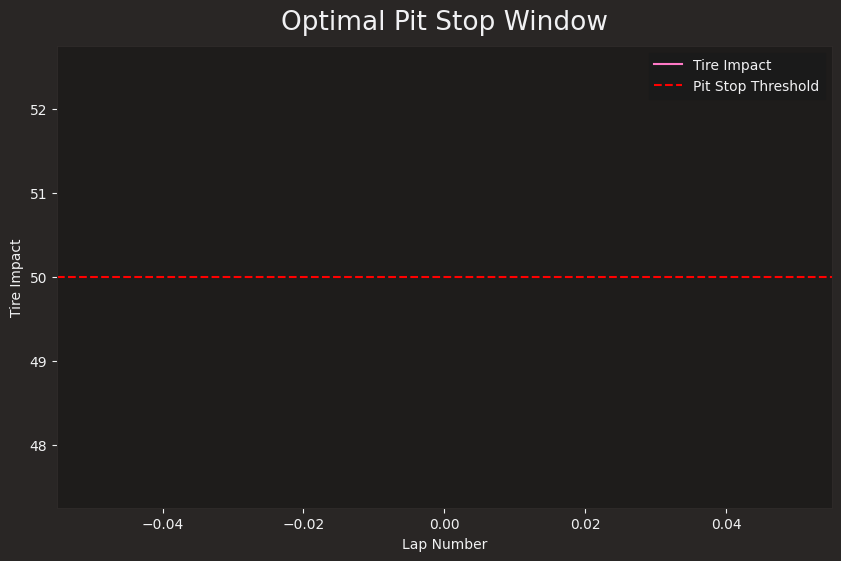

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def analyze_time_loss(driver_data, driver='Leclerc'):
    # Filter data for the selected driver
    
    # Calculate the difference between average RPM and tire life for each lap
    driver_data['TimeLost_RPM'] = driver_data['AvgRPM'].diff().fillna(0) * -0.01  # Arbitrary factor for RPM impact
    driver_data['TimeLost_TyreLife'] = driver_data['TyreLife'].diff().fillna(0) * 0.05  # Arbitrary factor for tire degradation
    
    # Calculate total time lost per lap based on RPM and tire life
    driver_data['TimeLost'] = driver_data['TimeLost_RPM'] + driver_data['TimeLost_TyreLife']
    
    # Plot Time Lost vs Lap Number to visualize degradation over time
    plt.figure(figsize=(10, 6))
    plt.plot(driver_data['LapNumber'], driver_data['TimeLost'], label=f'Time Lost per Lap ({driver})')
    plt.xlabel('Lap Number')
    plt.ylabel('Time Lost (s)')
    plt.title(f'Time Lost due to RPM and Tyre Degradation ({driver})')
    plt.legend()
    plt.show()
    
    return driver_data

def find_optimal_pit_stop(df):
    # Estimate the point where tire life starts to significantly impact lap times
    df['TireImpact'] = df['AvgSpeed'] * df['TyreLife'] / 1000  # Simple impact function
    pit_stop_window = df[df['TireImpact'] > 50]  # Threshold for significant tire impact (adjustable)
    # Visualize potential pit stop window
    plt.figure(figsize=(10, 6))
    plt.plot(pit_stop_window['LapNumber'], pit_stop_window['TireImpact'], label='Tire Impact')
    plt.axhline(50, color='red', linestyle='--', label='Pit Stop Threshold')
    plt.xlabel('Lap Number')
    plt.ylabel('Tire Impact')
    plt.title('Optimal Pit Stop Window')
    plt.legend()
    plt.show()

    return pit_stop_window

# Example Usage:
leclerc_sectors = analyze_time_loss(leclerc_sectors, driver='Leclerc')
verstappen_sectors = analyze_time_loss(verstappen_sectors, driver='Verstappen')

# Find optimal pit stop window for both drivers
leclerc_pit_stop_window = find_optimal_pit_stop(leclerc_sectors)
verstappen_pit_stop_window = find_optimal_pit_stop(verstappen_sectors)


In [12]:
import pandas as pd

# Assuming you have your data loaded as DataFrame `data`
# This will be used to calculate lap times during stints, accounting for tire degradation and pit stop windows
import pandas as pd

def calculate_lap_times(data, pit_stop_window):
    """
    Calculate lap times for each stint, considering degradation and pit stop window.
    """
    lap_times = []
    
    for index, row in data.iterrows():
        # Extract data for the current lap
        lap_number = row['LapNumber']
        avg_speed = row['AvgSpeed']
        avg_throttle = row['AvgThrottle']
        avg_brake = row['AvgBrake']
        avg_rpm = row['AvgRPM']
        tyre_life = row['TyreLife']
        compound = row['Compound']
        
        # Convert LapTime to seconds (assuming LapTime is a Timedelta)
        lap_time_seconds = row['LapTime'].total_seconds()  # Convert to seconds

        # Adjust lap time based on tire degradation and other factors
        degradation_factor = 1 + (tyre_life * 0.01)  # Adjust tire degradation factor (can be tweaked)
        time_loss = (avg_rpm * 0.0001) + (avg_speed * 0.0002)  # Adjust time loss based on RPM and speed
        
        # Simulate lap time with degradation
        lap_time = lap_time_seconds * degradation_factor + time_loss
        
        # If lap number is within the pit stop window, adjust lap time (pit stop effect)
        if lap_number in pit_stop_window:
            pit_time = 20  # Simulate pit stop time (this is an example, it can be adjusted)
            lap_time += pit_time
        
        lap_times.append(lap_time)
    
    return lap_times


# Example: Simulate lap times for both drivers
leclerc_lap_times = calculate_lap_times(leclerc_sectors, pit_stop_window=[20, 40, 60])  # Example pit stop window
verstappen_lap_times = calculate_lap_times(verstappen_sectors, pit_stop_window=[50, 60, 78])  # Example pit stop window

# Now, calculate cumulative race times
leclerc_total_time = sum(leclerc_lap_times)
verstappen_total_time = sum(verstappen_lap_times)

# Compare total times and predict race position
if leclerc_total_time < verstappen_total_time:
    print("Leclerc wins the race!")
else:
    print("Verstappen wins the race!")



Verstappen wins the race!


Impact of AvgRPM on lap time:
Slope: -0.01, R-squared: 0.38, P-value: 0.0000

Impact of TyreLife on lap time:
Slope: -0.75, R-squared: 0.36, P-value: 0.0000

Impact of AvgBrake on lap time:
Slope: -39.09, R-squared: 0.01, P-value: 0.1820

Impact of AvgThrottle on lap time:
Slope: -1.44, R-squared: 0.70, P-value: 0.0000

Impact of AvgSpeed on lap time:
Slope: -0.39, R-squared: 0.49, P-value: 0.0000


              LapTimeSeconds  AvgSpeed  AvgThrottle  AvgBrake    AvgRPM  \
LapTimeSeconds        1.000000 -0.698719    -0.833803 -0.099087 -0.620150   
AvgSpeed             -0.698719  1.000000     0.824717  0.109753  0.948886   
AvgThrottle          -0.833803  0.824717     1.000000 -0.056585  0.784019   
AvgBrake             -0.099087  0.109753    -0.056585  1.000000  0.079095   
AvgRPM               -0.620150  0.948886     0.784019  0.079095  1.000000   
TyreLife             -0.603497  0.459238     0.620003  0.100947  0.379182   

                TyreLife  
LapTimeSeconds -0.603497  
AvgSpeed        0.459238  
AvgThrottle     0.620003  
AvgBrake        0.100947  
AvgRPM          0.379182  
TyreLife        1.000000  


                LapTimeSeconds  AvgSpeed  AvgThrottle  AvgBrake    AvgRPM  \
LapTimeSeconds        1.000000 -0.714838    -0.911638 -0.148008 -0.582258   
AvgSpeed             -0.714838  1.000000     0.807554  0.312882  0.905743   
AvgThrottle          -0.911638  0.807554     1.000000  0.174936  0.701165   
AvgBrake             -0.148008  0.312882     0.174936  1.000000  0.371729   
AvgRPM               -0.582258  0.905743     0.701165  0.371729  1.000000   
TyreLife             -0.471933  0.388668     0.540351  0.065280  0.278316   

                TyreLife  
LapTimeSeconds -0.471933  
AvgSpeed        0.388668  
AvgThrottle     0.540351  
AvgBrake        0.065280  
AvgRPM          0.278316  
TyreLife        1.000000  

## EX. Found from online

In [29]:
hamilton_laps = hamilton_laps.loc[hamilton_laps['Stint'] == 1]
verstappen_laps = verstappen_laps.loc[verstappen_laps['Stint'] == 1]

hamilton_laps['RaceLapNumber'] = hamilton_laps['LapNumber'] - 1
verstappen_laps['RaceLapNumber'] = verstappen_laps['LapNumber'] - 1


full_distance_ver_lec = pd.DataFrame
summarized_distance_ver_lec = pd.DataFrame

for lap in verstappen_laps.iterlaps():
    telemetry = lap[1].get_car_data().add_distance().add_driver_ahead()
    
    # Only run this loop when driver ahead is RIC, otherwise we compare wrong distance gaps
    telemetry = telemetry.loc[telemetry['DriverAhead'] == "16"]
    
    if len(telemetry) != 0:
        # Full distance
        lap_telemetry = telemetry[['Distance', 'DistanceToDriverAhead']]
        lap_telemetry.loc[:, 'Lap'] = lap[0] + 1

        full_distance_ver_lec = full_distance_ver_lec.append(lap_telemetry)

        # Average / median distance
        distance_mean = np.nanmean(telemetry['DistanceToDriverAhead'])
        distance_median = np.nanmedian(telemetry['DistanceToDriverAhead'])

        summarized_distance_ver_lec = summarized_distance_ver_lec.append({
            'Lap': lap[0] + 1,
            'Mean': distance_mean,
            'Median': distance_median
        }, ignore_index = True)

In [34]:
laps_driver_1 = hamilton_laps
laps_driver_2 = verstappen_laps


# Select the fastest lap
fastest_driver_1 = laps_driver_1.pick_fastest()
fastest_driver_2 = laps_driver_2.pick_fastest()


# Retrieve the telemetry and add the distance column
telemetry_driver_1 = fastest_driver_1.get_telemetry()
telemetry_driver_2 = fastest_driver_2.get_telemetry()


# Make sure whe know the team name for coloring
team_driver_1 = fastest_driver_1['Team']
team_driver_2 = fastest_driver_2['Team']

AttributeError: 'NoneType' object has no attribute 'get_telemetry'

In [33]:
from fastf1 import utils
delta_time, ref_tel, compare_tel = utils.delta_time(fastest_driver_1, fastest_driver_2,)
plot_size = [15, 15]
plot_title = f"{session.year} {session.EventName} - {session.name} - LEC VER "
plot_ratios = [ 1, 3, 2, 1, 1, 2, 1]
plot_filename = plot_title.replace(" ", "") + ".png"


# Make plot a bit bigger
plt.rcParams['figure.figsize'] = plot_size

# Create subplots with different sizes
fig, ax = plt.subplots(7, gridspec_kw={'height_ratios': plot_ratios})

# Set the plot title
ax[0].title.set_text(plot_title)
#Delta line
#change plot colour to yellow
ax[0].plot(ref_tel['Distance'], delta_time, color='yellow')
ax[0].plot(ref_tel['Distance'], delta_time)
ax[0].axhline(0, color='white')
ax[0].set(ylabel=f"Gap to LEC (s)")

# Speed trace
ax[1].plot(telemetry_driver_1['Distance'], telemetry_driver_1['Speed'], label='LEC', color='r')
ax[1].plot(telemetry_driver_2['Distance'], telemetry_driver_2['Speed'], label='VER', color='b')
ax[1].set(ylabel='Speed')
ax[1].legend(loc="lower right")

# Throttle trace
ax[2].plot(telemetry_driver_1['Distance'], telemetry_driver_1['Throttle'], label='LEC', color='r')
ax[2].plot(telemetry_driver_2['Distance'], telemetry_driver_2['Throttle'], label='VER', color='b')
ax[2].set(ylabel='Throttle')

# Brake trace
ax[3].plot(telemetry_driver_1['Distance'], telemetry_driver_1['Brake'], label='LEC', color='r')
ax[3].plot(telemetry_driver_2['Distance'], telemetry_driver_2['Brake'], label='VER', color='b')
ax[3].set(ylabel='Brake')

# Gear trace
ax[4].plot(telemetry_driver_1['Distance'], telemetry_driver_1['nGear'], label='LEC', color='r')
ax[4].plot(telemetry_driver_2['Distance'], telemetry_driver_2['nGear'], label='VER', color='b')
ax[4].set(ylabel='Gear')

# RPM trace
ax[5].plot(telemetry_driver_1['Distance'], telemetry_driver_1['RPM'], label='LEC', color='r')
ax[5].plot(telemetry_driver_2['Distance'], telemetry_driver_2['RPM'], label='VER', color='b')
ax[5].set(ylabel='RPM')

# DRS trace
ax[6].plot(telemetry_driver_1['Distance'], telemetry_driver_1['DRS'], label='LEC',color='r')
ax[6].plot(telemetry_driver_2['Distance'], telemetry_driver_2['DRS'], label='VER', color='b')
ax[6].set(ylabel='DRS')
ax[6].set(xlabel='Lap distance (meters)')


# Hide x labels and tick labels for top plots and y ticks for right plots.
for a in ax.flat:
    a.label_outer()
    
# Store figure
plt.savefig(plot_filename, dpi=300)
plt.show()

/Users/nooralindeflaten/anaconda3/envs/INF273/lib/python3.11/site-packages/fastf1/utils.py:89: FutureWarning: `utils.delta_time` is considered deprecated and willbe modified or removed in a future release because it hasa tendency to give inaccurate results.
  warnings.warn("`utils.delta_time` is considered deprecated and will"


AttributeError: 'NoneType' object has no attribute 'get_car_data'

## TODO

In [16]:
import numpy as np
# Function to calculate the distance between two points (X, Y, Z)
def calculate_distance(pos1, pos2):
    return np.sqrt((pos2['X'] - pos1['X'])**2 + (pos2['Y'] - pos1['Y'])**2 + (pos2['Z'] - pos1['Z'])**2)

# Function to calculate the difference between two laps
def compare_laps(lap_data1, lap_data2, car_data1, car_data2):
    # Assuming lap_data1 and lap_data2 are two DataFrames with position data for consecutive laps
    # Assuming car_data1 and car_data2 are DataFrames with car telemetry data for those laps
    
    # Step 1: Pair position data
    pos_diffs = []
    for i in range(min(len(lap_data1), len(lap_data2))):  # Pair position data row by row
        pos1 = lap_data1.iloc[i]
        pos2 = lap_data2.iloc[i]
        dist = calculate_distance(pos1, pos2)  # Calculate the distance between positions
        pos_diffs.append(dist)
    
    # Step 2: Compare car data (RPM, Speed, etc.)
    car_diffs = []
    for i in range(min(len(car_data1), len(car_data2))):  # Pair car data row by row
        car1 = car_data1.iloc[i]
        car2 = car_data2.iloc[i]
        # Compare key telemetry features like RPM, Speed, Throttle
        rpm_diff = abs(car2['RPM'] - car1['RPM'])
        speed_diff = abs(car2['Speed'] - car1['Speed'])
        throttle_diff = abs(car2['Throttle'] - car1['Throttle'])
        car_diffs.append({'RPM_diff': rpm_diff, 'Speed_diff': speed_diff, 'Throttle_diff': throttle_diff})
    
    # Step 3: Compare Lap Times (we'll get the LapTime from each lap's data)
    lap_time_diff = abs(lap_data2['SessionTime'].iloc[0] - lap_data1['SessionTime'].iloc[0])
    
    # Return results as a dictionary or DataFrame for analysis
    return {
        'PositionDifferences': pos_diffs,
        'CarTelemetryDifferences': car_diffs,
        'LapTimeDifference': lap_time_diff
    }

# Example usage
lap1 = leclerc_laps[leclerc_laps['LapNumber'] == 1]
lap2 = leclerc_laps[leclerc_laps['LapNumber'] == 2]

# Extracting position and car data
lec_pos_data1, lec_car_data1 = lap1.get_pos_data(), lap1.get_car_data()
lec_pos_data2, lec_car_data2 = lap2.get_pos_data(), lap2.get_car_data()

# Compare the two laps
result = compare_laps(lec_pos_data1, lec_pos_data2, lec_car_data1, lec_car_data2)

# Print the result for inspection
print(result['LapTimeDifference'])

ValueError: Cannot slice telemetry because self contains no driver number!

Okey the position difference might not be needed, we probably could just choose X,Y,Z by taking lap1_X+lap2_X/2 etc. Because then we could see the trend of the driver later.
The way we could find the driving style would be to calculate this for all the laps, with matching coordinates, and then 

KeyError: 'SessionTime'

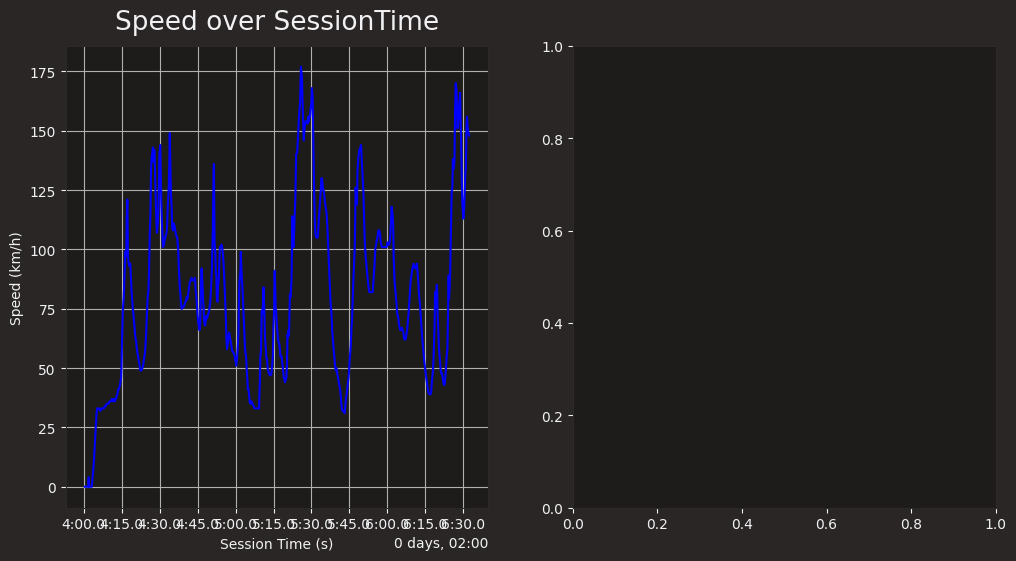

In [17]:
# Plot Speed vs SessionTime
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(lec_car_data['SessionTime'], lec_car_data['Speed'], label="Speed (km/h)", color="b")
plt.title("Speed over SessionTime")
plt.xlabel("Session Time (s)")
plt.ylabel("Speed (km/h)")
plt.grid(True)

# Plot LapTime vs SessionTime
plt.subplot(1, 2, 2)
plt.plot(single_lap['SessionTime'], single_lap['LapTime'], label="Lap Time (s)", color="r")
plt.title("Lap Time over SessionTime")
plt.xlabel("Session Time (s)")
plt.ylabel("Lap Time (s)")
plt.grid(True)

plt.tight_layout()
plt.show()

In [20]:

# Loop over car data for the single lap to analyze RPM, Speed, Throttle, Brake, DRS
def lap_analysis(laps,lap_num,driver_name):
    single_lap = laps[laps['LapNumber'] == lap_num]
#print(single_lap)
    lap_pos_data, lap_car_data = single_lap.get_pos_data(),single_lap.get_car_data()
    speeds = []
    throttles = []
    brakes = []
    rpms = []
    drs_usage = []
    x_coords = []
    y_coords = []
    z_coords = []
    for index, row in lap_car_data.iterrows():
        # Extract individual telemetry values for analysis
        rpm = row['RPM']
        speed = row['Speed']
        throttle = row['Throttle']
        brake = row['Brake']
        drs = row['DRS']
        # Optionally, print out or store these values for visualization
        #print(f"RPM: {rpm}, Speed: {speed}, Throttle: {throttle}, Brake: {brake}, DRS: {drs}")

    # Loop over position data for the single lap to analyze car position
    for index, row in lap_pos_data.iterrows():
        # Extract X, Y, Z coordinates
        x = row['X']
        y = row['Y']
        z = row['Z']
        # Optionally, print or store the position data to track the car's movement
        #print(f"X: {x}, Y: {y}, Z: {z}")
        
    # Initialize lists to store data for analysis
    speeds = []
    throttles = []
    brakes = []
    rpms = []
    drs_usage = []
    x_coords = []
    y_coords = []
    z_coords = []

    # Loop over car data for the single lap to analyze RPM, Speed, Throttle, Brake, DRS
    for index, row in lap_car_data.iterrows():
        speeds.append(row['Speed'])
        throttles.append(row['Throttle'])
        brakes.append(row['Brake'])
        rpms.append(row['RPM'])
        drs_usage.append(row['DRS'])

    # Loop over position data for the single lap to analyze car position
    for index, row in lap_pos_data.iterrows():
        x_coords.append(row['X'])
        y_coords.append(row['Y'])
        z_coords.append(row['Z'])

    print(f"{driver_name}  Telemetry analysis for lap {lap_num}")
    # Plot speed vs throttle and brake
    plt.figure(figsize=(10, 5))
    plt.subplot(2, 1, 1)
    plt.plot(speeds, label='Speed (km/h)', color='b')
    plt.plot(throttles, label='Throttle', color='g')
    plt.plot(brakes, label='Brake', color='r')
    plt.xlabel('Time (t)')
    plt.ylabel('Values')
    plt.legend()
    plt.title('Speed, Throttle, and Brake for Single Lap')

    # Plot RPM vs Speed
    plt.subplot(2, 1, 2)
    plt.plot(rpms, label='RPM', color='orange')
    plt.plot(speeds, label='Speed (km/h)', color='b')
    plt.xlabel('Time (t)')
    plt.ylabel('Values')
    plt.legend()
    plt.title('RPM vs Speed for Single Lap')

    plt.tight_layout()
    plt.show()
    '''
    # Plot position (X, Y) to track the car's movement on the track
    plt.figure(figsize=(6, 6))
    plt.plot(x_coords, y_coords, label="Car Movement (X vs Y)", color='purple')
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.title('Car Position on Track (X vs Y)')
    plt.grid(True)
    plt.legend()
    plt.show()
    
    # Plot DRS usage over time
    plt.figure(figsize=(8, 4))
    plt.plot(drs_usage, label='DRS Usage', color='cyan')
    plt.xlabel('Time (t)')
    plt.ylabel('DRS')
    plt.title('DRS Usage over Time (Single Lap)')
    plt.legend()
    plt.show()
    '''

lap_analysis(verstappen_laps,1,'VER')
lap_analysis(leclerc_laps,1,'LEC')

ValueError: Cannot slice telemetry because self contains no driver number!

In [ ]:
# Initialize lists to store data for all laps analysis
all_speeds = []
all_throttles = []
all_brakes = []
all_rpms = []
all_drs_usage = []
all_x_coords = []
all_y_coords = []
all_z_coords = []
all_lap_numbers = []
sector_times = {'Sector1': [], 'Sector2': [], 'Sector3': []}

# Loop over all laps for the driver
for lap_num, lap_data in leclerc_laps.iterrows():
    all_lap_numbers.append(lap_data['LapNumber'])
    
    # Get car data and position data for the lap
    lap_pos_data = lap_data.get_pos_data()
    lap_car_data = lap_data.get_car_data()
    
    # Loop over car data to get the telemetry information
    for index, row in lap_car_data.iterrows():
        all_speeds.append(row['Speed'])
        all_throttles.append(row['Throttle'])
        all_brakes.append(row['Brake'])
        all_rpms.append(row['RPM'])
        all_drs_usage.append(row['DRS'])

    # Loop over position data for the car's movement
    for index, row in lap_pos_data.iterrows():
        all_x_coords.append(row['X'])
        all_y_coords.append(row['Y'])
        all_z_coords.append(row['Z'])

    # Track sector times for each lap
    sector_times['Sector1'].append(lap_data['Sector1Time'])
    sector_times['Sector2'].append(lap_data['Sector2Time'])
    sector_times['Sector3'].append(lap_data['Sector3Time'])

# Plot Speed, Throttle, Brake over all laps
plt.figure(figsize=(10, 6))
plt.subplot(3, 1, 1)
plt.plot(all_speeds, label='Speed (km/h)', color='b')
plt.plot(all_throttles, label='Throttle', color='g')
plt.plot(all_brakes, label='Brake', color='r')
plt.xlabel('Time (t)')
plt.ylabel('Values')
plt.legend()
plt.title('Speed, Throttle, and Brake over All Laps')

# Plot RPM vs Speed over all laps
plt.subplot(3, 1, 2)
plt.plot(all_rpms, label='RPM', color='orange')
plt.plot(all_speeds, label='Speed (km/h)', color='b')
plt.xlabel('Time (t)')
plt.ylabel('Values')
plt.legend()
plt.title('RPM vs Speed over All Laps')

# Plot DRS Usage over all laps
plt.subplot(3, 1, 3)
plt.plot(all_drs_usage, label='DRS Usage', color='cyan')
plt.xlabel('Time (t)')
plt.ylabel('DRS')
plt.title('DRS Usage over All Laps')
plt.legend()
plt.tight_layout()
plt.show()

# Plot Position (X, Y) for the entire race to visualize car movement
plt.figure(figsize=(8, 8))
plt.plot(all_x_coords, all_y_coords, label="Car Movement (X vs Y)", color='purple')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Car Position on Track (X vs Y) for All Laps')
plt.grid(True)
plt.legend()
plt.show()

# Plot Sector Times across all laps
plt.figure(figsize=(10, 5))
plt.plot(sector_times['Sector1'], label='Sector 1 Time', color='blue')
plt.plot(sector_times['Sector2'], label='Sector 2 Time', color='green')
plt.plot(sector_times['Sector3'], label='Sector 3 Time', color='red')
plt.xlabel('Lap Number')
plt.ylabel('Sector Time (s)')
plt.title('Sector Times over All Laps')
plt.legend()
plt.show()


Here's how we can approach this:
1. Loop through All Laps:
We'll loop through each lap and analyze car_data and pos_data to calculate performance metrics. We can look at things like speed, throttle, RPM, and position data. From there, we'll focus on sector times to break down the lap into smaller chunks.

2. Break Down the Lap into Sectors:
We'll use the sector1, sector2, and sector3 data to divide the lap into sectors. Each sector represents a key part of the lap, so analyzing these sectors will help us see where Leclerc lost or gained time.

3. Time Differences:
By calculating the differences in time between laps and sectors, we can compare Leclerc's performance across multiple laps.

4. Adding Features:
As we analyze the data, we can start adding more features like tire compounds, DRS usage, etc. These will help us explain why Leclerc performed differently on certain laps.

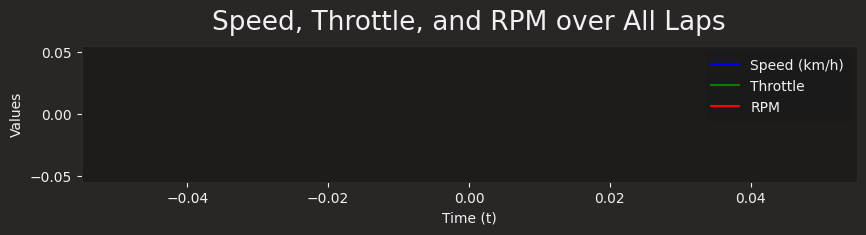

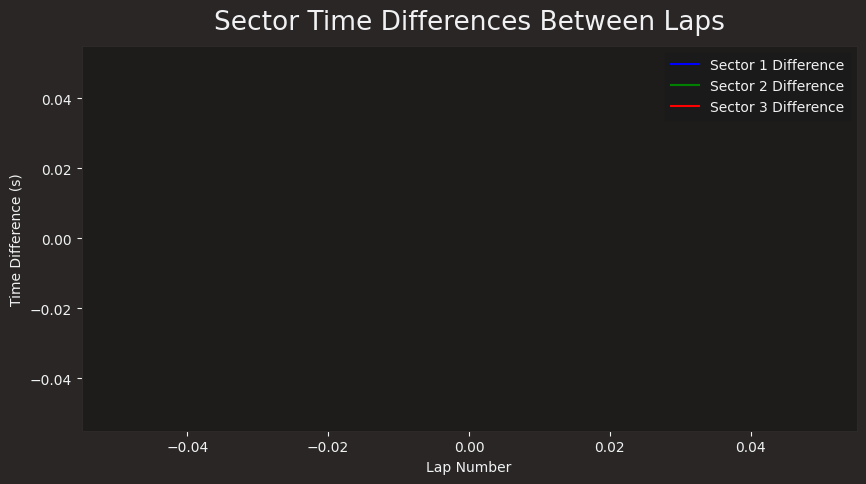

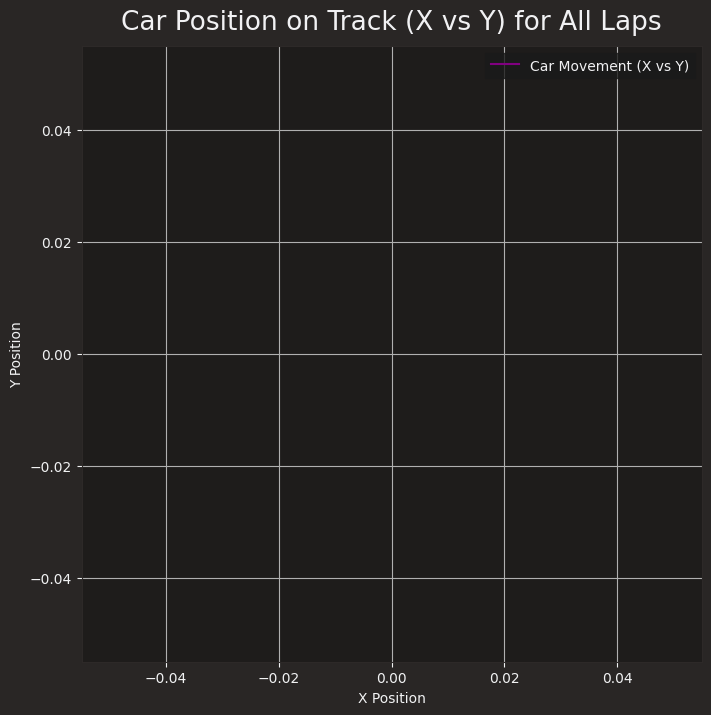

In [19]:
# Initialize lists to store lap data for comparison
all_lap_times = []
all_sectors = {'Sector1': [], 'Sector2': [], 'Sector3': []}
all_speeds = []
all_throttles = []
all_rpms = []
all_x_coords = []
all_y_coords = []
all_z_coords = []

# Loop through all laps for Leclerc and analyze car and position data
for lap_num, lap_data in leclerc_laps.iterrows():
    # Get car and position data for the lap
    lap_pos_data = lap_data.get_pos_data()
    lap_car_data = lap_data.get_car_data()
    
    # Track speed, throttle, RPM, and car position data for the lap
    speed_data = []
    throttle_data = []
    rpm_data = []
    x_coords = []
    y_coords = []
    z_coords = []

    # Loop through car data for telemetry information
    for _, row in lap_car_data.iterrows():
        speed_data.append(row['Speed'])
        throttle_data.append(row['Throttle'])
        rpm_data.append(row['RPM'])

    # Loop through position data for car movement
    for _, row in lap_pos_data.iterrows():
        x_coords.append(row['X'])
        y_coords.append(row['Y'])
        z_coords.append(row['Z'])

    # Calculate sector times using sector data available in lap
    sector_1_time = lap_data['Sector1Time']
    sector_2_time = lap_data['Sector2Time']
    sector_3_time = lap_data['Sector3Time']
    
    all_lap_times.append(lap_data['LapTime'])
    all_sectors['Sector1'].append(sector_1_time)
    all_sectors['Sector2'].append(sector_2_time)
    all_sectors['Sector3'].append(sector_3_time)
    
    all_speeds.extend(speed_data)
    all_throttles.extend(throttle_data)
    all_rpms.extend(rpm_data)
    all_x_coords.extend(x_coords)
    all_y_coords.extend(y_coords)
    all_z_coords.extend(z_coords)

# Calculate the lap-to-lap differences (time differences) and performance per sector
lap_time_differences = [all_lap_times[i] - all_lap_times[i-1] for i in range(1, len(all_lap_times))]

# Analyze sector performance per lap
sector_1_diff = [all_sectors['Sector1'][i] - all_sectors['Sector1'][i-1] for i in range(1, len(all_sectors['Sector1']))]
sector_2_diff = [all_sectors['Sector2'][i] - all_sectors['Sector2'][i-1] for i in range(1, len(all_sectors['Sector2']))]
sector_3_diff = [all_sectors['Sector3'][i] - all_sectors['Sector3'][i-1] for i in range(1, len(all_sectors['Sector3']))]

# Plot Speed, Throttle, RPM over all laps
plt.figure(figsize=(10, 6))
plt.subplot(3, 1, 1)
plt.plot(all_speeds, label='Speed (km/h)', color='b')
plt.plot(all_throttles, label='Throttle', color='g')
plt.plot(all_rpms, label='RPM', color='r')
plt.xlabel('Time (t)')
plt.ylabel('Values')
plt.legend()
plt.title('Speed, Throttle, and RPM over All Laps')

# Plot sector time differences
plt.figure(figsize=(10, 5))
plt.plot(sector_1_diff, label='Sector 1 Difference', color='blue')
plt.plot(sector_2_diff, label='Sector 2 Difference', color='green')
plt.plot(sector_3_diff, label='Sector 3 Difference', color='red')
plt.xlabel('Lap Number')
plt.ylabel('Time Difference (s)')
plt.title('Sector Time Differences Between Laps')
plt.legend()
plt.show()

# Plot position (X, Y) for the entire race to visualize car movement
plt.figure(figsize=(8, 8))
plt.plot(all_x_coords, all_y_coords, label="Car Movement (X vs Y)", color='purple')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Car Position on Track (X vs Y) for All Laps')
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
from sklearn.linear_model import LinearRegression
import numpy as np

def simulate_race(df, driver_data):
    # Simulate the race based on time loss due to pit stops and tire degradation
    driver_data['CumulativeTimeLost'] = driver_data['TimeLost'].cumsum()  # Cumulative time loss over the race
    driver_data['TotalRaceTime'] = driver_data['LapTimeSeconds'] + driver_data['CumulativeTimeLost']  # Add time lost due to pit stops
    
    # Assuming lap times can be added together (simplified model)
    total_race_time = driver_data['TotalRaceTime'].iloc[-1]  # Total time for the race (including all pits)
    
    return total_race_time

# Simulate for both Leclerc and Verstappen
leclerc_race_time = simulate_race(leclerc_laps,leclerc_sectors)
verstappen_race_time = simulate_race(verstappen_laps, verstappen_sectors)

# Predict final race position based on total race times
if leclerc_race_time < verstappen_race_time:
    print("Leclerc wins the race!")
else:
    print("Verstappen wins the race!")
